In [1]:
import json
import os
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statistics import mode

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import rioxarray

from xrspatial import focal, slope
import seaborn as sns
from tqdm import tqdm
from joblib_progress import joblib_progress
from xrspatial.multispectral import ndvi, savi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss


In [2]:
# paths
helena_path = Path.cwd().parent / 'data' / 'helena'
pred_path = helena_path / 'predictions_g100.parquet'

In [3]:
# open crowns with predictions
pred_df = gpd.read_parquet(pred_path).set_index('UniqueID')

In [30]:
print(f'of {len(pred_df)} crowns:')
print(f'{((pred_df.pred_2020) > pred_df.pred_2018).sum()} increase probability of being alive between 2018 and 2020')
print(f'{((pred_df.pred_2022 > pred_df.pred_2020)).sum()} increase probability of being alive between 2020 and 2022')
print(f'{((pred_df.pred_2022 > pred_df.pred_2018)).sum()} increase probability of being alive between 2018 and 2022')

of 97 crowns:
69 increase probability of being alive between 2018 and 2020
44 increase probability of being alive between 2020 and 2022
56 increase probability of being alive between 2018 and 2022


In [34]:
buf = 0.05
print(f'of {len(pred_df)} crowns:')
print(f'{((pred_df.pred_2020 - buf) > pred_df.pred_2018).sum()} increase probability of being alive between 2018 and 2020')
print(f'{((pred_df.pred_2022 - buf) > pred_df.pred_2020).sum()} increase probability of being alive between 2020 and 2022')
print(f'{((pred_df.pred_2022 - buf) > pred_df.pred_2018).sum()} increase probability of being alive between 2018 and 2022')

of 97 crowns:
41 increase probability of being alive between 2018 and 2020
25 increase probability of being alive between 2020 and 2022
37 increase probability of being alive between 2018 and 2022


<Axes: >

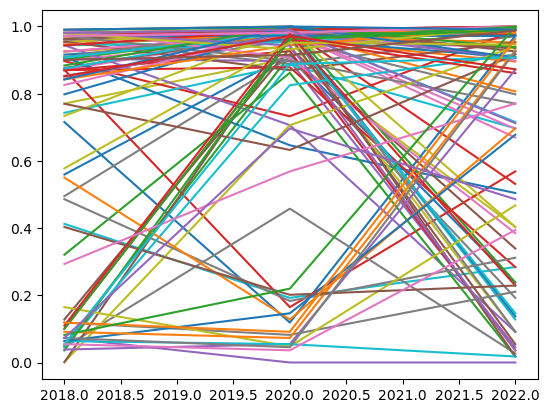

In [25]:
t_series = pred_df[['pred_2018', 'pred_2020', 'pred_2022']].T
t_series.index = 2018, 2020, 2022
t_series.plot(legend=False)

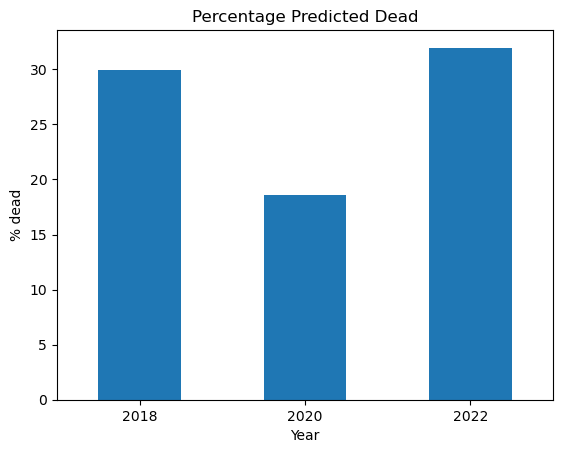

In [95]:
treatment_df = pred_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead');


In [52]:
pred_df.treatment.unique()

array([ 0,  3, 12])

In [79]:
alive_df

pred_2018    30.0
pred_2020    30.0
pred_2022    28.0
dtype: float64

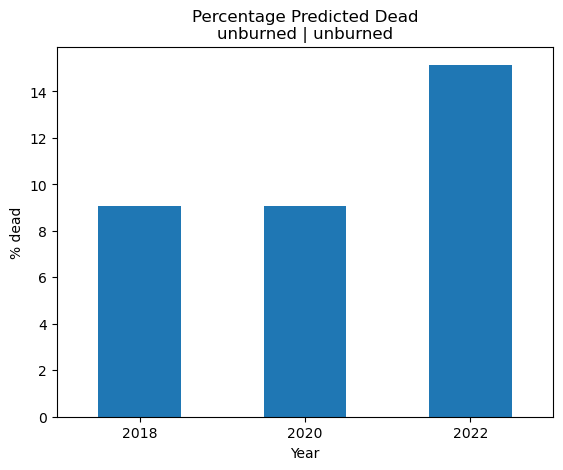

In [92]:
treatment = 0
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nunburned | unburned');


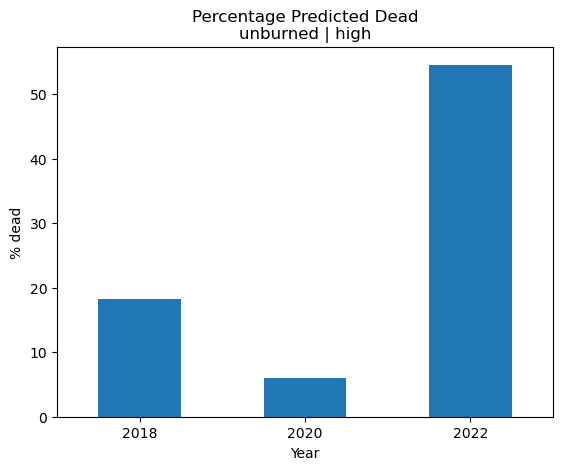

In [93]:
treatment = 3
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nunburned | high');

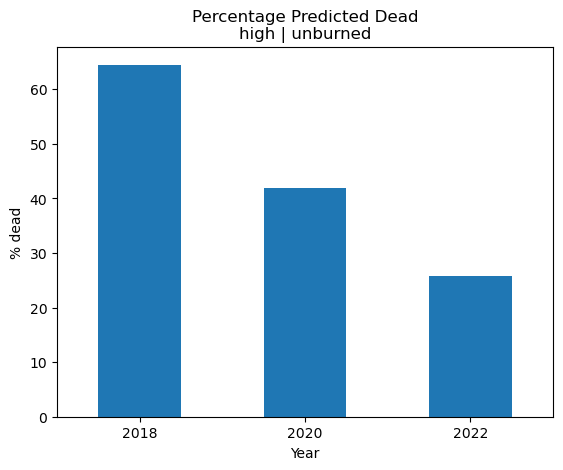

In [94]:
treatment = 12
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nhigh | unburned');

In [ ]:
treatment = 12
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nhigh | unburned');